<a href="https://colab.research.google.com/github/so-yeon-hwang/DataSciencePractice/blob/main/Reservoir_DGIM_FajloetMartin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task1

In [ ]:
import random

class Reservoir:
    def __init__(self, k):  # 몇개 뽑을 것인가?
        self.size = k
        self.data = [None] * k
        self.cnt = 0

    def add(self, x):
        if self.cnt < self.size:  # 아직 배열 안채워짐
            self.data[self.cnt] = x
        else:  # 사이즈보다 넘었다. 이미 k개의 칸이 다 찼으니 주사위 돌리기
            c = random.randint(0, self.cnt)  # c chance
            if c < self.size:
                self.data[c] = x
            else:
                pass  # box 안 변화 없음
        self.cnt += 1

    def get_samples(self):
        return self.data[:self.cnt]


k = int(input('배열의 크기(사용자 지정): '))
samplers = {}

# 사이즈 1짜리 Reservoir Sampling algorithm k개가 돌아간다
for i in range(k):
    samplers["sampler_{}".format(i)] = Reservoir(1)

for i in range(100):
    for j in range(k):
        samplers["sampler_{}".format(j)].add(i)

# 결과 출력
for key, sampler in samplers.items():
    print(f"{key}: {sampler.get_samples()}")


배열의 크기(사용자 지정): 5
sampler_0: [27]
sampler_1: [58]
sampler_2: [15]
sampler_3: [15]
sampler_4: [54]


# Task2

In [ ]:
class Block:
    def __init__(self, ts, te, sum_value):
        self.ts = ts
        self.te = te
        self.sum_value = sum_value

    def __str__(self):
        return f"({self.ts}, {self.te}, {self.sum_value})"

    def __repr__(self):
        return f"({self.ts}, {self.te}, {self.sum_value})"


class DGIM_Method1:
    def __init__(self, max_bits):
        self.levels = []
        self.timestamp = 0
        self.max_bits = max_bits

    def add_integer(self, num):  # Add an integer by breaking it into bits
        bit_representation = f'{num:0{self.max_bits}b}'
        for bit in bit_representation:
            self.add_bit(int(bit))

    def add_bit(self, bit): # bit = 0 or 1
        self.timestamp += 1

        if bit == 0:
            return

        lv = 0
        ts = self.timestamp - 1
        te = self.timestamp

        while True:
            if len(self.levels) == lv:
                self.levels.append([])

            if len(self.levels[lv]) < 2:
                self.levels[lv].append(Block(ts, te, 1))
                return
            elif len(self.levels[lv]) == 2:
                new_block = Block(ts, te, 1)
                ts = self.levels[lv][0].ts
                te = self.levels[lv][1].te

                self.levels[lv].clear()
                self.levels[lv].append(new_block)

                lv += 1

    def sum_last_k_integers(self, int_stream, k):
        bit_count = k * self.max_bits
        bit_stream = int_stream_to_bit_stream(int_stream[-k:], self.max_bits)
        self.__init__(self.max_bits)
        for bit in bit_stream:
            self.add_bit(bit)

        total_bits = self.sum_last_k_bits(bit_count)
        return total_bits

    def sum_last_k_bits(self, k):
        tt = self.timestamp - k
        sum_value = 0
        for lv, blocks in enumerate(self.levels):
            for blk in reversed(blocks):
                if tt <= blk.ts:
                    sum_value += (1 << lv)
                elif tt < blk.te:
                    fraction = (blk.te - tt) / (blk.te - blk.ts)
                    sum_value += (1 << lv) * fraction
                    return sum_value
                else:
                    return sum_value

        return sum_value


class DGIM_Method2:
    def __init__(self):
        self.levels = []
        self.timestamp = 0
        self.current_block = None

    def add(self, x): # x = integer (0 or positive integer)
        self.timestamp += 1

        if x == 0:
            return

        if self.current_block is None:
            self.current_block = Block(self.timestamp - 1, self.timestamp, x)
        else:
            self.current_block.te += 1
            self.current_block.sum_value += x

        lv = 0
        while True:
            if len(self.levels) == lv:
                self.levels.append([])

            if len(self.levels[lv]) < 2:
                self.levels[lv].append(self.current_block)
                self.current_block = None
                return
            elif len(self.levels[lv]) == 2:
                new_block = Block(self.current_block.ts, self.current_block.te, self.current_block.sum_value)
                ts = self.levels[lv][0].ts
                te = self.levels[lv][1].te
                sum_value = self.levels[lv][0].sum_value + self.levels[lv][1].sum_value

                self.levels[lv].clear()
                self.levels[lv].append(new_block)

                self.current_block = Block(ts, te, sum_value)
                lv += 1

    def sum_last_k_integers(self, k):
        tt = self.timestamp - k
        sum_value = 0
        for lv, blocks in enumerate(self.levels):
            for blk in reversed(blocks):
                if tt <= blk.ts:
                    sum_value += blk.sum_value
                elif tt < blk.te:
                    fraction = (blk.te - tt) / (blk.te - blk.ts)
                    sum_value += blk.sum_value * fraction
                    return sum_value
                else:
                    return sum_value

        return sum_value


# integer -> bit stream
def int_stream_to_bit_stream(int_stream, max_bits):
    bit_stream = []
    for number in int_stream:
        bit_representation = f'{number:0{max_bits}b}'
        bit_stream.extend(int(bit) for bit in bit_representation)
    return bit_stream


In [ ]:
# Test both methods
int_stream = [2, 3, 4, 5, 0, 5, 4, 5, 7, 4, 3, 0, 4, 6, 0, 1, 2, 3, 5, 6, 0, 7, 3, 2, 2, 1, 4, 0, 5, 2, 3]
max_bits = 4  # Assuming the maximum integer is 15, so we need 4 bits to represent it

dgim1 = DGIM_Method1(max_bits)
dgim2 = DGIM_Method2()

k = 5

for number in int_stream:
    dgim1.add_integer(number)
    dgim2.add(number)

print("Method 1 - Estimated sum of the last", k, "integers:", dgim1.sum_last_k_integers(int_stream, k))
print("Method 2 - Estimated sum of the last", k, "integers:", dgim2.sum_last_k_integers(k))


Method 1 - Estimated sum of the last 5 integers: 6
Method 2 - Estimated sum of the last 5 integers: 14


In [ ]:
# Test both methods
int_stream = [ 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]
max_bits = 4  # Assuming the maximum integer is 15, so we need 4 bits to represent it

dgim1 = DGIM_Method1(max_bits)
dgim2 = DGIM_Method2()

k = 5

for number in int_stream:
    dgim1.add_integer(number)
    dgim2.add(number)

print("Method 1 - Estimated sum of the last", k, "integers:", dgim1.sum_last_k_integers(int_stream, k))
print("Method 2 - Estimated sum of the last", k, "integers:", dgim2.sum_last_k_integers(k))


Method 1 - Estimated sum of the last 5 integers: 4
Method 2 - Estimated sum of the last 5 integers: 4


# Task 3

In [ ]:
!pip install mmh3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 2.1 MB/s eta 0:00:00


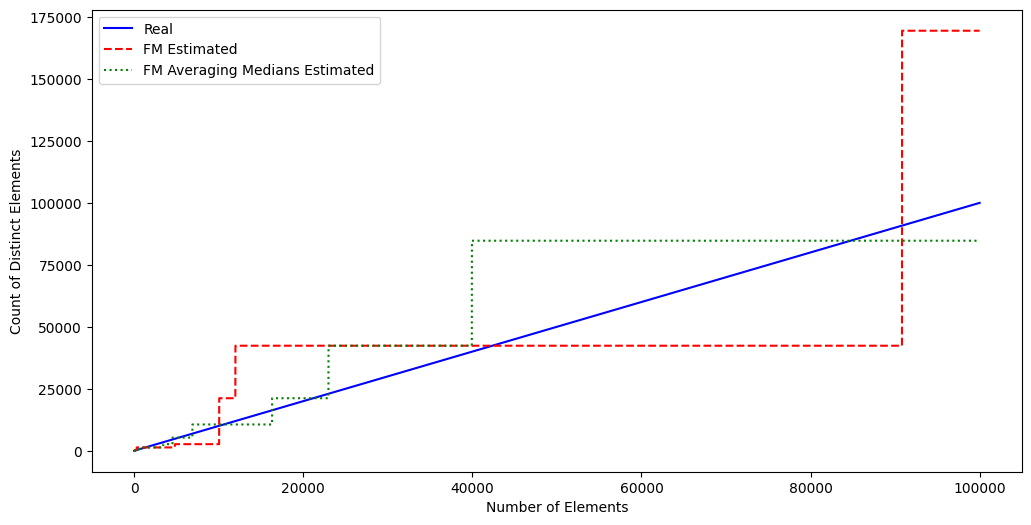

0b1101111100001010000
0b10000
4


In [ ]:
import mmh3
import numpy as np
import matplotlib.pyplot as plt

class FM:
    def __init__(self, seed):
        self.B = 0
        self.seed = seed

    def add(self, x):
        h = mmh3.hash(x, self.seed)
        r = (h & -h).bit_length() - 1
        self.B |= (1 << r)

    def get_count(self):
        rev = ~self.B
        r = (rev & -rev).bit_length() - 1
        return (2 ** r) / 0.77351

class FM_AveragingMedians:
    def __init__(self, num_hashes):
        self.num_hashes = num_hashes
        self.fm_list = [FM(seed) for seed in range(num_hashes)]

    def add(self, x):
        for fm in self.fm_list:
            fm.add(x)

    def get_count(self):
        estimates = [fm.get_count() for fm in self.fm_list]
        median_of_means = np.median(estimates)
        return median_of_means

seed = 4
fm = FM(seed)
fm_avg_median = FM_AveragingMedians(21)
gold = set()
n = 100000

X = []
Y = []
Y_avg_median = []

for i in range(n):
    fm.add(str(i))
    fm_avg_median.add(str(i))
    gold.add(str(i))

    X.append(i + 1)  # 실제 distinct 한 item의 수
    Y.append(fm.get_count())  # fm에 의해 예측된 distinct 한 item의 수
    Y_avg_median.append(fm_avg_median.get_count())  # 평균 중간값에 의해 예측된 distinct 한 item의 수

plt.figure(figsize=(12, 6))
plt.plot(X, label="Real", color='blue')
plt.plot(Y, label="FM Estimated", color='red', linestyle='dashed')
plt.plot(Y_avg_median, label="FM Averaging Medians Estimated", color='green', linestyle='dotted')
plt.xlabel("Number of Elements")
plt.ylabel("Count of Distinct Elements")
plt.legend()
plt.show()

a = 456784
print(bin(a))
print(bin(a & -a))
print((a & -a).bit_length() - 1)
